In [1]:
import numpy as np
from scipy.sparse import coo_matrix
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Import user-item rating dataframe

ratings_red = pd.read_json('ratings_vreduced.json')

In [3]:
# Determine how many user-item pairs are filled

n_users = len(ratings_red.user.unique())
n_games = len(ratings_red.gameid.unique())
sparsity = float(len(ratings_red))/(n_users*n_games)*100
print str(sparsity)+'% of user-item ratings are filled.'

8.79270223819% of user-item ratings are filled.


In [4]:
# Convert user names and game IDs to matrix indices

userdict = {}
for i, user in enumerate(ratings_red.user.unique()):
    userdict[user] = i
    
gamedict = {}
for i, game in enumerate(ratings_red.gameid.unique()):
    gamedict[game] = i
    
ratings_red['user'] = ratings_red['user'].map(userdict.get)
ratings_red['gameid'] = ratings_red['gameid'].map(gamedict.get)

In [5]:
# Split data in testing and training sets

X = ratings_red[['gameid','user']]
y = ratings_red['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29, stratify=X['user'])

In [25]:
# Build a user-item score matrix from training data

train = coo_matrix((y_train, (X_train['user'],X_train['gameid'])))
train = train.todense()

In [26]:
def fillavg(ratings):
    """This function fills the empty items in a rating matrix with the item average score"""
    rate = pd.DataFrame(ratings.copy())
    rate[rate==0] = np.nan
    rate = rate.fillna(rate.mean())
    return rate.as_matrix()

In [27]:
# Determine a 'baseline' score predition where all missing scores are predicted by the item's average score

pred_baseline = fillavg(train)

In [28]:
def rmse(X, y, prediction):
    """This function calculates mean squared-error of the prediction.
    Inputs are a dataframe of indices, a dataframe of scores, and the matrix of predicted values"""
    y_pred = []
    for row in X.itertuples():
        y_pred.append(prediction[row[2],row[1]])
    return np.sqrt(mean_squared_error(y, y_pred))

In [29]:
# Calculate RMSE for baseline model

print 'RMSE: ' + str(rmse(X_test,y_test,pred_baseline))

RMSE: 1.3723781512


In [30]:
def uu_similarity(ratings):
    ratings2 = ratings + 1e-10
    similarity = ratings2.dot(ratings2.T)
    norms = np.matrix(np.sqrt(similarity.diagonal()))
    return similarity/norms/norms.T

In [31]:
def uu_predict(ratings, similarity):
    similarity2 = similarity.copy()
    np.fill_diagonal(similarity2, 0)
    predictions = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings!= 0))
    return predictions

In [32]:
sim = uu_similarity(train)

In [14]:
pred = uu_predict(train, sim)

In [15]:
print 'RMSE: ' + str(rmse(X_test,y_test,pred))

RMSE: 1.36863782534


In [16]:
def uu_predict_topk(ratings, similarity, k):
    similarity2 = similarity.copy()
    np.fill_diagonal(similarity2, 0)
    nanfill = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings!= 0))
    filt = similarity2.argsort()[:,:len(similarity2)-k]
    for index, row in enumerate(filt):
        similarity2[index,row]=0
    predictions = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings != 0))
    predictions = pd.DataFrame(predictions).fillna(pd.DataFrame(nanfill))
    return predictions.as_matrix()

In [17]:
rmse_test = []
ks = [10,25,50,100,250,500,1000,2000,3000]
for k in ks:
    pred_topk = uu_predict_topk(train, sim.copy(), k)
    rmse_test.append(rmse(X_test,y_test,pred_topk))

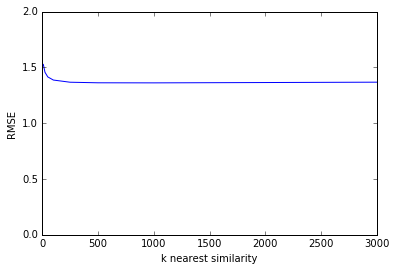

In [19]:
plt.plot(ks, rmse_test)
plt.ylim([0,2])
plt.xlim([0,3000])
plt.xlabel('k nearest similarity')
plt.ylabel('RMSE')
plt.show()

In [162]:
def unbias(ratings):
    rate = pd.DataFrame(ratings.copy().T)
    rate[rate == 0] = np.nan
    means = rate.mean()
    rate = (rate-means).fillna(0)
    return rate.as_matrix().T, means

In [163]:
def rebias(ratings, means):
    rate = pd.DataFrame(ratings.copy().T)
    rate = rate+means
    rate[rate > 10] = 10
    rate[rate < 1] = 1
    return rate.as_matrix().T

In [22]:
train_unbias, means = unbias(train)

In [23]:
sim_unbias = uu_similarity(train_unbias)

In [24]:
pred_unbias = uu_predict(train_unbias, sim_unbias)
pred_unbias = rebias(pred_unbias, means)

In [25]:
rmse(X_test,y_test,pred_unbias)

1.184754839754125

In [26]:
rmse_test_unbias = []
ks = [10,25,50,100,250,500,1000,2000,3000]
for k in ks:
    pred_unbias_topk = uu_predict_topk(train_unbias, sim_unbias, k)
    pred_unbias_topk = rebias(pred_unbias_topk, means)
    rmse_test_unbias.append(rmse(X_test,y_test,pred_unbias_topk))

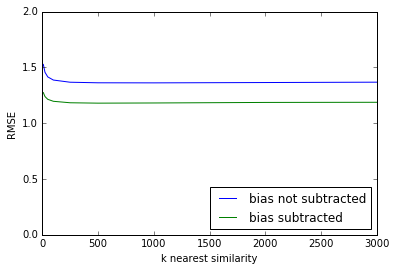

In [30]:
plt.plot(ks, rmse_test)
plt.plot(ks, rmse_test_unbias)
plt.ylim([0,2])
plt.xlim([0,3000])
plt.xlabel('k nearest similarity')
plt.ylabel('RMSE')
plt.legend(['bias not subtracted', 'bias subtracted'], loc = 4)
plt.show()

## Testing on my own account

In [126]:
my_ratings = pd.read_json('my_ratings.json')
my_ratings2 = my_ratings.copy()
my_ratings2['gameid'] = my_ratings2['gameid'].map(gamedict.get)

In [127]:
my_ratings_mat = coo_matrix((my_ratings2.score, (np.zeros_like(my_ratings2.gameid),my_ratings2.gameid)), shape = [1, n_games]).todense()

In [128]:
full_ratings = coo_matrix((y, (X['user'],X['gameid']))).todense()

In [166]:
my_ratings_unbias, my_mean = unbias(my_ratings_mat)
full_ratings_unbias, full_means = unbias(full_ratings)

In [129]:
def su_similarity(u_ratings, ratings):
    norms = np.sqrt(full_ratings.dot(full_ratings.T).diagonal())
    denom = norms * np.linalg.norm(my_ratings)
    return np.divide(u_ratings.dot(full_ratings.T), denom)

In [130]:
my_sim = su_similarity(my_ratings_unbias, full_ratings_unbias)

In [202]:
def su_predict_topk(ratings, similarity, k):
    similarity2 = similarity.copy()
    filt = similarity2.argsort()[:,:len(similarity2)-k]
    for index, row in enumerate(filt):
        similarity2[index,row]=0
    predictions = np.divide(similarity2.dot(ratings),np.abs(similarity2).dot(ratings != 0))
    return predictions

In [203]:
my_pred = su_predict_topk(full_ratings_unbias, my_sim, 1000)
my_pred = rebias(my_pred, my_mean)
my_pred = pd.DataFrame(my_pred).transpose()
my_pred.columns = ['predicted_score']

In [154]:
game_df = pd.read_json('bgg_database.json')['name']
game_df.index.name = 'gameid'
game_df = game_df.reset_index()

In [205]:
recommendations = pd.DataFrame.from_dict(gamedict, orient = 'index').reset_index()
recommendations.columns = ['gameid','index']
recommendations = recommendations.set_index('index').sort_index()
del recommendations.index.name
recommendations = recommendations.join(my_pred)
recommendations = recommendations.merge(game_df, how = 'left', left_on = 'gameid', right_on = 'gameid')

In [206]:
owned_filter = recommendations.gameid.isin(my_ratings.gameid)

In [222]:
recommendations[~owned_filter].sort_values('predicted_score', ascending = False).head(20)

,gameid,predicted_score,name
5259,27266,10.000000,Silent Death: The Next Millennium Deluxe Edition
4975,248949,10.000000,Skull Tales: Full Sail!
101,68250,9.912898,Objective: Kiev
5730,3408,9.867956,This Accursed Civil War
6823,5985,9.687181,Miscellaneous Game Accessory
5944,37257,9.658741,The Uncharted Seas
3258,18746,9.617956,Gustav Adolf the Great: With God and Victoriou...
1190,1313,9.581778,1826: Railroading in France and Belgium from 1826
1327,1358,9.414547,Field Command
6042,38764,9.305827,Shuuro
